# Lock-In Example

This is an example notebook showing how to use the `lockin` module, which provides software lock-in amplifier classes.

In [128]:
%matplotlib inline
from __future__ import division
import numpy as np
from scipy import signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import sigutils
import lockin
plt.rc('font', size=11)
plt.rc('figure', figsize=(3, 2.5))


# Overview

Let's generate some example data.

In [129]:
fs = 1e3
T = 10
dt = 1/fs
N = int(round(T*fs))
t = np.arange(N)*dt - T/2

def gaussian(x, loc, sigma):
    return np.exp(-(x-loc)**2 / (2*sigma**2))

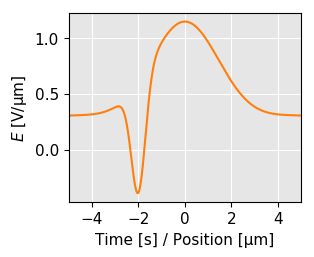

In [131]:

m_noiseless = (
    gaussian(t, 0.0, 1.5) - gaussian(t, -2, 0.3)*1 +
    gaussian(t, 5, 3)*0.3 + gaussian(t, -5, 3)*0.3
    )
fig = plt.figure()
ax = plt.subplot(facecolor='0.9')
l1, = ax.plot(0, 0)
c1 = l1.get_color()
l2, = ax.plot(t, m_noiseless, linewidth=1.5)
c2 = l2.get_color()
ax.set_xlim(-5, 5)
# plt.xticks([-0.4, 0, 0.4])
ax.set_xlabel(u"Time [s] / Position [µm]")
ax.set_ylabel(u"$E$ [V/µm]")
ax.grid(color='1')
fig.savefig('Ex-signal.pdf', bbox_inches='tight')

In [134]:
!mv Ex-signal.pdf /Users/ryandwyer/Research/Talks/1703-digital-lock-in-amplifier/beamer/figs/

This is the expected signal we are hoping our lock-in will recover. Then, we create the modulated signal, and add experimental nosie.

In [119]:
f_m = 50.0 # Modulation frequency
m_modulated = m_noiseless*np.sin(2*np.pi*f_m*t + 0.12)
noise = signal.lfilter(*signal.butter(1, np.pi * 1 / 500.0), x=np.random.randn(N)*1)
m_measured = m_modulated + noise

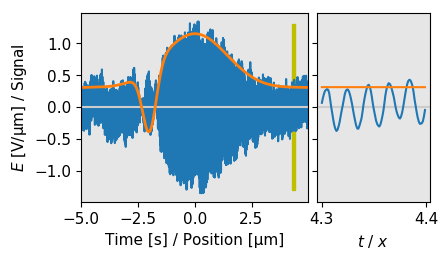

In [136]:
fig, (ax, ax2) = plt.subplots(figsize=(4.5, 2.5), sharey=True, ncols=2, subplot_kw=dict(facecolor='0.9'), gridspec_kw={'width_ratios': (2, 1)})
# ax.grid(color='1', zorder=0)
fig.subplots_adjust(wspace=0.05)
ax.plot(t, m_noiseless, linewidth=2, zorder=2, color=c2)
ax.plot(t, m_measured, zorder=1, color=c1)
m = (t > 4.3 ) &  (t < 4.4)
ax2.plot(t[m], m_noiseless[m], linewidth=1.5, zorder=2, color=c2)
ax2.plot(t[m], m_measured[m], zorder=1, color=c1)
ax.axvspan(4.3, 4.4, ymin=0.06, ymax=0.94, color='y', zorder=0)
ax.set_xticks(np.arange(-5, 4.9, 2.5))
ax.set_xlim(-5, 5)
ax.axhline(color='0.8', zorder=1.5)
ax2.axhline(color='0.8', zorder=0.5)
# plt.xticks([-0.4, 0, 0.4])
ax.set_xlabel(u"Time [s] / Position [µm]")
ax.set_ylabel(u"$E$ [V/µm] / Signal")
ax2.set_xlabel(u"$t$ / $x$")
fig.savefig('Ex-signal-mod.pdf', bbox_inches='tight')

In [137]:
!mv Ex-signal-mod.pdf /Users/ryandwyer/Research/Talks/1703-digital-lock-in-amplifier/beamer/figs/

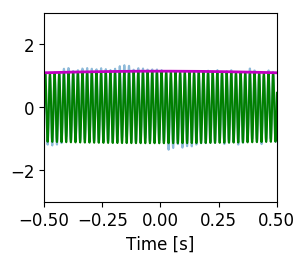

In [58]:
plt.plot(t, m_measured, alpha=0.5)
plt.plot(t, m_modulated, color='g')
plt.plot(t, m_noiseless, color='m', linewidth=2)
plt.xlim(-0.5, 0.5)
plt.ylim(-3, 3)
plt.xlabel("Time [s]")

Now we apply the lock-in amplifier to the modulated signal. First, we create the LockIn object by passing the time array, lock-in input array, and sampling frequency.

In [6]:
li = lockin.LockIn(t, m_measured, fs=fs)

Next, we choose and apply a lock-in filter.  The lock-in filter bandwidth is set by the `bw` argument of the lock function. It is important that the lock-in filter *strongly*  rejects the modulation frequency `f0`.

In [12]:
li.lock(bw=20.0, f0=500.0)

Response:
f   mag       dB
  0.000 1.000    0.000
 10.000 0.996   -0.034
 20.000 0.500   -6.021
250.000 0.000 -137.352
500.000 0.000 -151.857
5000.000 0.000 -353.887


The printed values show the lock-in filter response function evaluated at key frequencies. The second to last is the reference frequency `f0`.

The lock-in will pick out the reference frequency automatically by using the maximum of the Fourier transform by default.
If you want to specify the reference frequency, use the `f0` argument to the `lock` function. Next, we need to phase the lock-in correctly so we maximize the signal in the `X` channel.
There are two convenience functions for phasing the lock-in, `phase` and `autophase`.

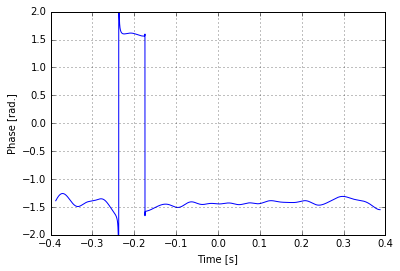

In [13]:
plt.plot(li('t'), li('phi'))
plt.xlabel('Time [s]')
plt.ylabel("Phase [rad.]")
plt.ylim(-2, 2)
plt.grid()

From the plot, we can see the correct phase is roughly -1.5 radians (The phase "reverses" by $\pi$, to +1.6 radians when the sign of the signal changes). We can phase the lock-in with  three functions:

`autophase`: performs a best-fit to minimize the phase difference, taking into account phase reversals, over the time range `ti` to `tf`.

`phase`: performs a simple least-squares fit to pick the optimal `phi0`, over the time range `ti` to `tf`.

`manual_phase`: Calculate output channels `X`, `Y` for a manually selected `phi0`.

By default, `autophase`, and `phase` also updates the reference frequency to correct any drift in the phase. This can be turned off by using the option, `adjust_f0=False`.

In [14]:
li.autophase()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1


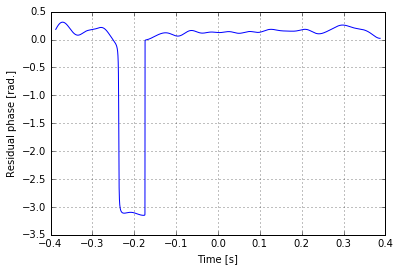

In [15]:
plt.plot(li('t'), li('dphi'))
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel("Residual phase [rad.]")

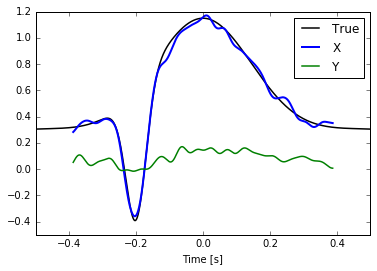

In [16]:
plt.plot(t, m_noiseless, 'k', linewidth=1.5, label="True")
plt.plot(li('t'), li('X'), linewidth=2, label="X")
plt.plot(li('t'), li('Y'), linewidth=1.5, label="Y")
plt.legend()
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 1.2)
plt.xlabel('Time [s]')

The lock-in X channel output is displayed in the above plot, compared to the actual signal.
A few things to note:

- The lock-in output is available over only a portion of the input time array, because of the length of the finite impulse response (FIR) filter. To reduce the missing portion of the signal, reduce `coeff_ratio` in the lock argument.